# Insurance with Regression Model

#### Imported needed modules

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from pandas import read_csv, DataFrame
from xgboost import XGBRegressor
from scipy.stats import skew
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

#### Reading information relevant to us from files

In [16]:
training_data = read_csv('files_for_train/train.csv')
test_data = read_csv('files_for_train/test.csv')

#### Data for the train kit

In [17]:
print(training_data.shape)
training_data.head()

(1200000, 21)


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


#### Data for the test kit

In [18]:
print(test_data.shape)
test_data.head()

(800000, 20)


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


#### Number of columns and names of these columns for both data sets

In [19]:
def display_content_of_data(dataset):
    print("Liczba kolumn: ")
    print(len(dataset.columns.to_list()))
    print("Kolumny: ")
    for column in dataset.columns.to_list():
        print(column)

display_content_of_data(training_data)

Liczba kolumn: 
21
Kolumny: 
id
Age
Gender
Annual Income
Marital Status
Number of Dependents
Education Level
Occupation
Health Score
Location
Policy Type
Previous Claims
Vehicle Age
Credit Score
Insurance Duration
Policy Start Date
Customer Feedback
Smoking Status
Exercise Frequency
Property Type
Premium Amount


In [20]:
display_content_of_data(test_data)

Liczba kolumn: 
20
Kolumny: 
id
Age
Gender
Annual Income
Marital Status
Number of Dependents
Education Level
Occupation
Health Score
Location
Policy Type
Previous Claims
Vehicle Age
Credit Score
Insurance Duration
Policy Start Date
Customer Feedback
Smoking Status
Exercise Frequency
Property Type


#### Data allocation

In [21]:
all_columns = training_data.iloc[:, :-1]
premium_amounts = training_data.iloc[:, -1]

#### The sum of null data for each column in the case of a test and training kit

In [22]:
training_data.isnull().sum()

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [23]:
test_data.isnull().sum()

id                           0
Age                      12489
Gender                       0
Annual Income            29860
Marital Status           12336
Number of Dependents     73130
Education Level              0
Occupation              239125
Health Score             49449
Location                     0
Policy Type                  0
Previous Claims         242802
Vehicle Age                  3
Credit Score             91451
Insurance Duration           2
Policy Start Date            0
Customer Feedback        52276
Smoking Status               0
Exercise Frequency           0
Property Type                0
dtype: int64

#### Dividing data into categorical and numerical.

What are these types of data?
 - Numerical data - a type of data that consists of numbers and can be subjected to mathematical, operations such as age or annual income. 
 - Categorical data - a type of data that represents categories and can be divided into groups, such as marital status or gender.

####    Let's display categorical columns

In [24]:
numerical_columns = all_columns.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = all_columns.select_dtypes(exclude=[np.number]).columns.tolist()

print(categorical_columns)

['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']


#### Filling categorical data with the word "Missing", and numerical data - average from all data from this type of column

In [25]:
training_data[numerical_columns] = training_data[numerical_columns].fillna(training_data[numerical_columns].mean())
training_data[categorical_columns] = training_data[categorical_columns].fillna("Missing")
test_data[numerical_columns] = test_data[numerical_columns].fillna(test_data[numerical_columns].mean())
test_data[categorical_columns] = test_data[categorical_columns].fillna("Missing")

#### Checking after such cleaning the amount of null data in the columns 

In [26]:
training_data.isnull().sum()

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
dtype: int64

In [27]:
test_data.isnull().sum()

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
dtype: int64

####    Preparing numerical data for display.

In [28]:
numerical_data = training_data.select_dtypes(include=["number"])
numerical_data = numerical_data.drop(columns=["id"])
numerical_data = numerical_data.drop(columns=["Premium Amount"])

#### Correlation matrix

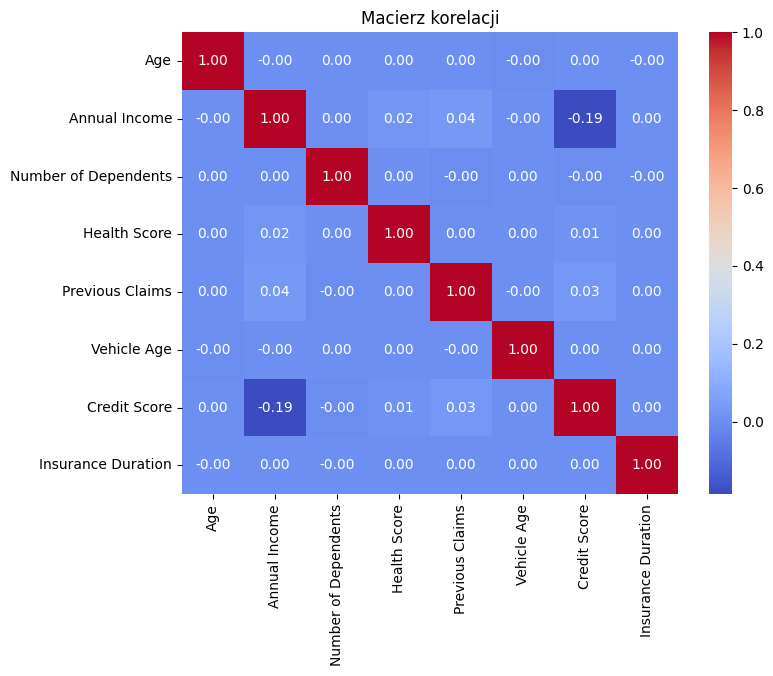

In [29]:
def make_correlation_matrix():
    correlation_matrix = numerical_data.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Macierz korelacji")
    plt.show()

make_correlation_matrix()

####    Checking for outliers looking at box plots - an effective method for identifying outliers.

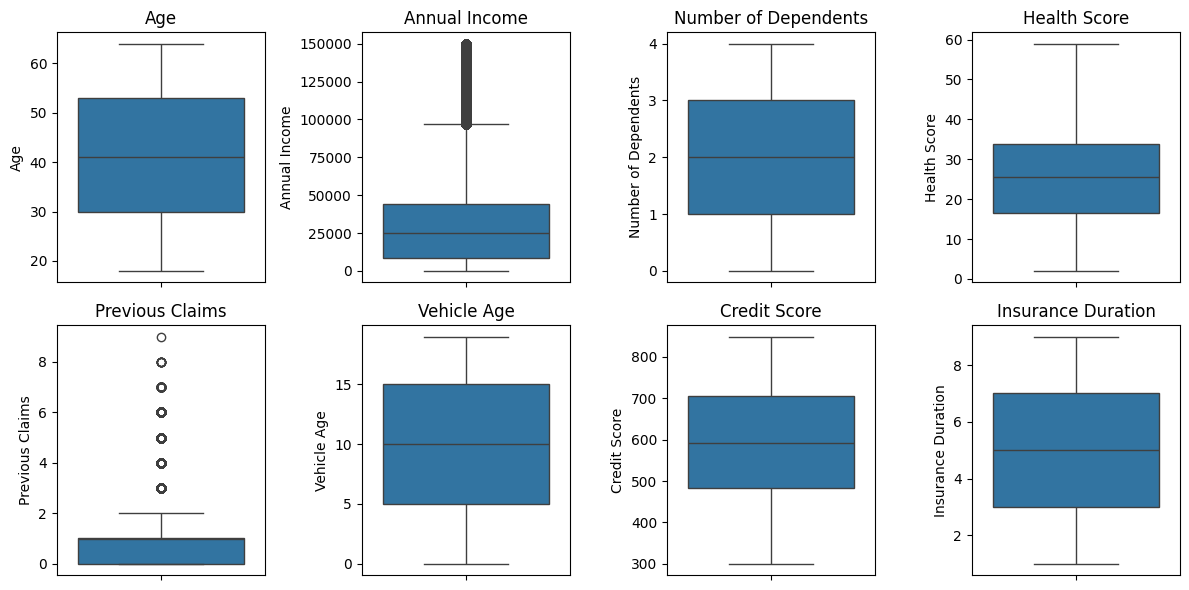

In [30]:
numerical_features = numerical_data.columns.to_list()

def make_numerical_features_plots(dataset):
        plt.figure(figsize=(12, 6))
        for ax, feature in enumerate(numerical_features, 1):
                plt.subplot(2, 4, ax)
                sns.boxplot(y=dataset[feature])
                plt.title(feature)
        plt.tight_layout()
        plt.show()

make_numerical_features_plots(training_data)

Except "Previous Claims" and "Annual Income", all features have normal distribution. Since these two features have an asymmetrical distribution, we will attempt to remove outliers.
Firstly, we should calculate skewness to determine the best method for outlier removal.

In [31]:
dataframe = DataFrame(training_data["Annual Income"])
skewness = skew(dataframe["Annual Income"])

print(skewness)

1.498692094589285


This value is greater than 0 so we will choose the IQR method.

In [32]:
def remove_outliers(dataset, column):
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data_without_outliers = dataset[(dataset[column] >= lower_bound) & (dataset[column] <= upper_bound)]
    return data_without_outliers

training_data_without_outliers = remove_outliers(training_data, "Previous Claims")
training_data_without_outliers = remove_outliers(training_data_without_outliers, "Annual Income")


Now, let's see if we still have any outliers.

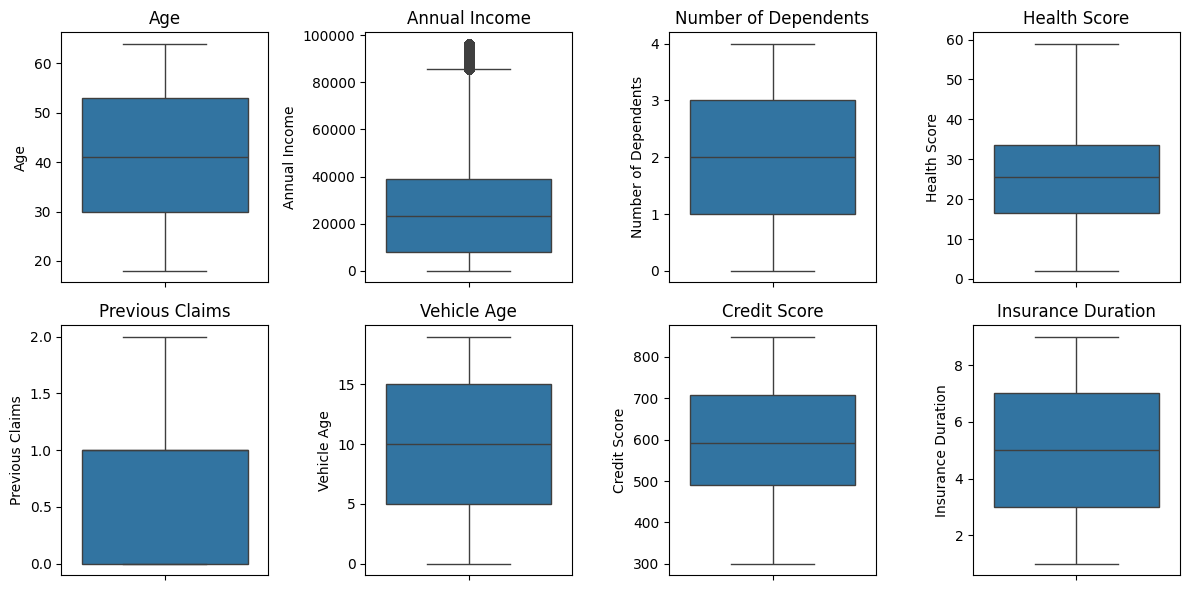

In [33]:
make_numerical_features_plots(training_data_without_outliers)

There are still outliers in the Annual Income category. In our case, it is caused, because new outliers appeared after data modification – sometimes, removing part of the data changes the statistics (e.g., the median, quartiles), which could cause other points to be flagged as outliers.

#### After removing outlayer and null data, let's split data

In [34]:
for column in categorical_columns:
    training_data_without_outliers[column] = training_data_without_outliers[column].astype('category')

X = training_data_without_outliers.drop('Premium Amount', axis=1)
y = training_data_without_outliers['Premium Amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#### Checking for unique values in each categorical column

In [35]:
#   Date isn't categorical type of date - so we can do another list of categorical set without this type.
categorical_columns_without_date = [cat_column for cat_column in categorical_columns if cat_column != 'Policy Start Date']

def display_unique_values():
    for cat_column in categorical_columns_without_date:
        print(cat_column)
        print(training_data[cat_column].unique().tolist())

display_unique_values()

Gender
['Female', 'Male']
Marital Status
['Married', 'Divorced', 'Single', 'Missing']
Education Level
["Bachelor's", "Master's", 'High School', 'PhD']
Occupation
['Self-Employed', 'Missing', 'Employed', 'Unemployed']
Location
['Urban', 'Rural', 'Suburban']
Policy Type
['Premium', 'Comprehensive', 'Basic']
Customer Feedback
['Poor', 'Average', 'Good', 'Missing']
Smoking Status
['No', 'Yes']
Exercise Frequency
['Weekly', 'Monthly', 'Daily', 'Rarely']
Property Type
['House', 'Apartment', 'Condo']


Some of the categorical features can be logically expressed as numbers (for example smoking status 1 means yes, 0 means no). Other features like excersices can be turned into frequency scale. We will use StandardScaler for standardizing numerical data and OneHotEncoder for easier categorization of categorical data.

In [36]:
all_columns = training_data_without_outliers.iloc[:, :-1]
premium_amounts = training_data_without_outliers.iloc[:, -1]

numerical_features = all_columns.select_dtypes(include=[np.number]).columns
categorical_features = all_columns.select_dtypes(exclude=[np.number]).columns


numerical_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

transformers = [
        ("numerical", numerical_transformer, numerical_features),
        ("categorical", categorical_transformer, categorical_features)
    ]

data_transformer = ColumnTransformer(transformers)

Here, we also use a Pipeline, which will allow us to perform multiple operations simultaneously to speed up model computations and dataset transformations.

In [37]:
data_transformer.fit_transform(test_data)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 15757195 stored elements and shape (800000, 158818)>

#### Let's create XGBRegressor object

In [38]:
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=7,
    eta=0.1,
    subsample=0.7,
    enable_categorical=True
    )

We use a Pipeline here so that before creating the model, the pipeline transforms the datasets.

In [39]:
pipeline = Pipeline(steps=[
    ("prepared_data", data_transformer),
    ("xgb_regressor", xgb_model)
])

Below, pipeline model was matched to the data set

In [40]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepared_data',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='igno...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, ...))])

####    Prediction based on X_test data

In [41]:
predicted_y = pipeline.predict(X_test)

print(predicted_y)

[1054.1461 1081.2203 1137.3131 ... 1267.7361 1059.8987 1060.4849]


####    Cross Validation

In [61]:
def cross_validation(parts: int) -> float:
    oof_preds = cross_val_predict(pipeline, all_columns, premium_amounts, cv=parts)
    mse = mean_squared_log_error(premium_amounts, oof_preds)
    rmse = sqrt(mse)
    return rmse

We determined the RMSE for parameters from 2 to 10, but the best RMSE result was achieved with validation for cv=10, which is:

In [60]:
print(f"Overall CV RMSE = {cross_validation(10):.5f}")

Overall CV RMSE = 1.12696


####    Prediction based on configured test_data

In [43]:
y_test_pred = pipeline.predict(test_data)

We save data to file as score of model's prediction.

In [44]:
submission = read_csv('files_for_train/sample_submission.csv')
submission['Premium Amount'] = y_test_pred
submission.to_csv('scores/submit.csv',index=False)

####    Our model's scores

In [45]:
submission.head()

,id,Premium Amount
0,1200000,1283.851440
1,1200001,1122.408691
2,1200002,1075.452881
3,1200003,1085.074463
4,1200004,1035.593140


####    Let's create another model - simple Linear Model, where we do it in the same way as in the pipeline model.

In [46]:
linear_model = LinearRegression()

In [47]:
linear_model_pipeline = Pipeline(steps=[
    ("prepared_data", data_transformer),
    ("simple_regressor", linear_model)
])

In [48]:
linear_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepared_data',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
       'Policy Type', 'Policy Start Date', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type'],
      dtype='object'))])),
                ('simple_regressor', LinearRegression())])

In [49]:
predictions = linear_model_pipeline.predict(X_test)

print(predictions)

[1098.72947695  982.03966987 1027.5673298  ...  975.04064278 1318.18074718
 1103.40904391]


In [50]:
test_predictions = linear_model_pipeline.predict(test_data)

####    Errors comparison

In [51]:
xgb_model_mse = mean_squared_error(y_test, predicted_y)
xgb_model_r2_score = r2_score(y_test, predicted_y)

print(f"Mean Squared Error for XGBRegressor model: {xgb_model_mse}")
print(f"R2 score for XGBRegressor model: {xgb_model_r2_score}")

Mean Squared Error for XGBRegressor model: 684871.8435605034
R2 score for XGBRegressor model: 0.04490782815263383


In [52]:
linear_model_mse = mean_squared_error(y_test, predictions)
linear_model_r2_score = r2_score(y_test, predictions)

print(f"Mean Squared Error for LinearRegression model: {linear_model_mse}")
print(f"R2 score for LinearRegression model: {linear_model_r2_score}")

Mean Squared Error for LinearRegression model: 860476.9339386687
R2 score for LinearRegression model: -0.19998331277206693


According to the metrics below, it is evident that the pipeline model, which effectively uses the xgb_model, is better than the simple linear regression model, which meets our expectations.